In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
from ugvc.reports.report_utils import ReportUtils
from ugvc.reports.report_data_loader import ReportDataLoader
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("talk")

In [4]:
run_id = "NA"
pipeline_version = "NA"
statistics_file = "comp.json"
verbosity = 3
reference_version = "hg38"
truth_sample_name = "NA"
h5outfile = "var_report.h5"    


In [5]:
parameters = {
    'statistics_file': statistics_file,
    'run_id': run_id,
    'pipeline_version': str(pipeline_version),
    'verbosity': str(verbosity),
    'reference_version': reference_version,
    'truth_sample_name': truth_sample_name,
    'h5outfile': h5outfile,
}

parameters = {name: parameters[name] for name in parameters if parameters[name] is not None}
param_names = list(parameters)

report_utils = ReportUtils(verbosity, h5outfile)

display(Markdown(f"# SV/CNV Calling report {pipeline_version} (INTERNAL usage)"))


# SV/CNV Calling report NA (INTERNAL usage)

## 1. Input Parameters <a class="anchor" id="input_parameters"></a>

In [6]:
parameters['statistics_file'] = "/data/Runs/VariantCalling/work/250507/test.stats.json"

In [7]:
# load data
data_loader = ReportDataLoader(concordance_file=parameters['statistics_file'],
                               reference_version=parameters['reference_version'],
                               exome_column_name = "exome.twist"
)
data_no_gt, data_gt = data_loader.load_sv_concordance_df()

In [8]:
parameters_df = pd.DataFrame.from_dict(parameters, orient='index', columns=['value']).reindex(param_names)
parameters_df.to_hdf(h5outfile, key="parameters")
display(parameters_df)

,value
statistics_file,/data/Runs/VariantCalling/work/250507/test.stats.json
run_id,NA
pipeline_version,NA
verbosity,3
reference_version,hg38
truth_sample_name,NA
h5outfile,var_report.h5


In [10]:
anchor = report_utils.get_anchor("top")
display(Markdown(f"## Table of Contents {anchor}"))
tc = "* [Input Parameters](#input_parameters)\n"
tc += "* [General statistics](#general_statistics)\n"
if data_gt is not None:
    tc += "* [Accuracy](#gen_acc_all_data)\n"

display(Markdown(tc))

## Table of Contents <a class ='anchor' id='top'> </a>

* [Input Parameters](#input_parameters)
* [General statistics](#general_statistics)
* [Accuracy](#gen_acc_all_data)


## General statistics  <a class='anchor' id='all_data'></a>

The tables below summarize class and length distributions of called SVs


### SV type distribution

In [13]:
pd.options.display.float_format = '{:,.2%}'.format
data_no_gt['type_counts'].index = ['SV type']
data_no_gt['type_counts']

,DEL,INS,DUP,CTX,BND
SV type,9436,7497,935,653,383


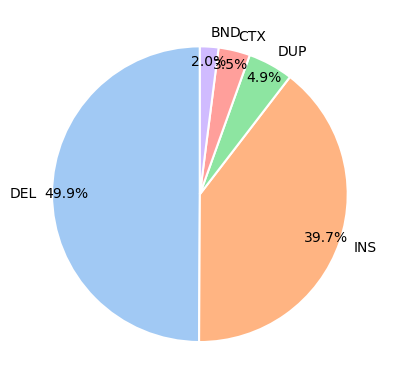

In [ ]:
# Pie chart of data_no_gt['type_counts']
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data_no_gt['type_counts'].values[0],
                                   labels=data_no_gt['type_counts'].columns,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   colors=sns.color_palette("pastel"),
                                    pctdistance=0.9,         # keep percentages inside
                                    labeldistance=1.1,        # move labels outside

                                   textprops=dict(color="b"))
for text in texts + autotexts:
    text.set_color("black")
    text.set_fontsize(10)

### SV length distribution

In [20]:
data_no_gt['length_counts'].index = ['SV Length']
data_no_gt['length_counts']

,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
SV Length,11016,2943,3114,316,580,130,82,17,53


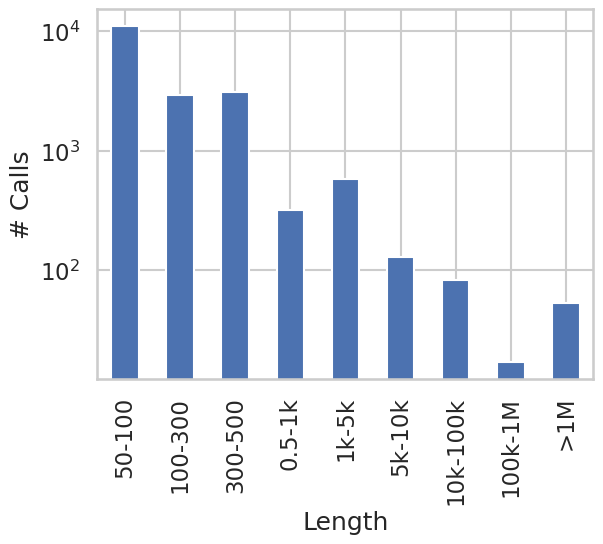

In [23]:
data_no_gt['length_counts'].T.plot.bar(legend=False)
plt.xlabel("Length")
plt.ylabel('# Calls')
# set y axis log scale
plt.yscale('log')


### Length and type distribution

In [28]:
data_no_gt['length_by_type_counts'].set_index('svtype', inplace=True)
data_no_gt['length_by_type_counts']

,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
svtype,,,,,,,,,
BND,42,55,36,58,110,12,22,8,40
DEL,6365,1167,1099,210,431,110,48,5,1
DUP,578,187,54,41,39,8,12,4,12
INS,4031,1534,1925,7,0,0,0,0,0


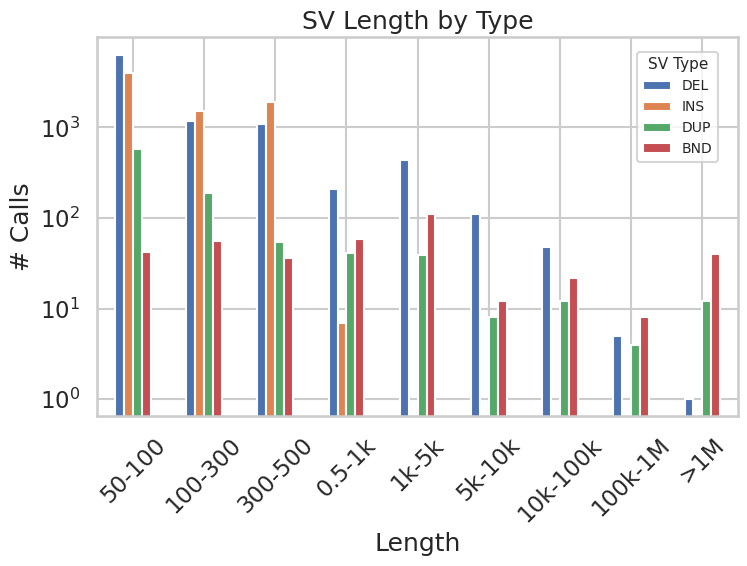

In [ ]:
# Make sure the SV types are in the desired order
desired_order = ['DEL', 'INS', 'DUP', 'BND']
df = data_no_gt['length_by_type_counts']
df = df.set_index('svtype') if 'svtype' in df.columns else df
df = df.reindex(desired_order).dropna(how='all')

# Plot with legend inside and correct order
ax = df.T.plot(kind='bar', stacked=False, figsize=(8, 6))
plt.xlabel("Length")
plt.ylabel('# Calls')
plt.title('SV Length by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(
    title='SV Type',
    loc='upper right',   # inside the plot
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10,
    title_fontsize=11
)
plt.yscale('log')
plt.show()


## 2. Performance over all Data <a class="anchor" id="all_data"></a> 
The concordance between the variant calling results and the ground truth sample is presented below.
* Red line - precision and recall over different tree-scores.
* Red dot - precision and recall values for the chosen threshold.
* Black dot -precision and recall after filtering systematic errors (SEC)

[top](#top)

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
if verbosity > 1:
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
              'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8',
              'hmer Indel >8,<=10', 'hmer Indel >10,<=12', 'hmer Indel >12,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
else:
    categories = ['SNP', 'Indel']

report_utils.basic_analysis(data, categories, 'all_data', 'sec_data')

In [ ]:
if verbosity > 1:
    anchor = report_utils.get_anchor('all_data_bases')
    display(Markdown(f"## 2.1 Stratified by base {anchor}"))
    display(Markdown(f"#### (A,T)"))
    categories = ['SNP', 'Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10',
                  'hmer Indel >10,<=12', 'hmer Indel >12,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
    at_df = report_utils.base_stratification_analysis(data, categories, ('A', 'T'))

In [ ]:
if verbosity > 1:
    display(Markdown(f"#### (G,C)"))
    categories = ['SNP', 'Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10']
    gc_df = report_utils.base_stratification_analysis(data, categories,('G', 'C')) 
    
    base_strat_df = pd.concat([at_df, gc_df])
    report_utils.make_multi_index(base_strat_df)
    base_strat_df.to_hdf(h5outfile, key="all_data_per_base")

In [ ]:
if verbosity > 1:
    anchor = report_utils.get_anchor('all_data_hom')
    display(Markdown(f"### 2.2 Homozygous genotyping accuracy {anchor}"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classified as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 
                  'hmer Indel >8,<=10', 'hmer Indel >10,<=12', 'hmer Indel >12,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
    report_utils.homozygous_genotyping_analysis(data, categories, "all_data_homozygous")

## 3. Performance over UG high confidence regions <a class="anchor" id="ug_hcr"></a>

Variant calling peformance exclusing genomic areas where UG performance is poor, i.e:
- Homopolymers - runs of length 11 bp and above, padded with four bases around the genomic coordinates,
- AT-rich regions - bases where the GC content of the surrounding 40 bases is lower than 5%,
- Tandem repeats,
- Low mapping quality - regions that are covered by at least 20 reads, but less than 10% of these reads are aligned with mapping quality > 20,
- High coverage variability - regions with coverage that is highly variable between samples (std/mean > 0.5)

[top](#top)

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
ug_hcr_data = data.query("ug_hcr==True").copy()

if verbosity > 1:
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
              'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8', 'hmer Indel >8,<=10']
else:
    categories = ['SNP', 'Indel']
    
report_utils.basic_analysis(ug_hcr_data, categories, 'ug_hcr', 'ug_hcr_sec_data')

In [ ]:
if verbosity > 1:
    anchor = report_utils.get_anchor('ug_hcr_hom')
    display(Markdown(f"### 3.1 Homozygous genotyping accuracy {anchor}"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classified as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10']
    report_utils.homozygous_genotyping_analysis(ug_hcr_data, categories, "ug_hcr_homozygous")

## 4. Performance over exome <a class="anchor" id="exome"></a>
Performance over exome regions (defined in exome_column_name)

[top](#top)

In [ ]:
exome_data = data[data[exome_column_name]].copy()

if verbosity > 1:
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'hmer Indel <=4', 'hmer Indel >4,<=8', 'hmer Indel >8,<=10']
else:
    categories = ['SNP', 'Indel']
    
report_utils.basic_analysis(exome_data, categories, 'exome', 'exome_sec_data')


In [ ]:
if verbosity > 1:
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:.2f}'.format
    anchor = report_utils.get_anchor('exome_indel_errors')
    present_columns = [x for x in ['alleles',  'call', 'base', 'gt_ultima', 'gt_ground_truth', 'ad',
                                    'max_vaf', 'ug_hcr', 'mappability.0', 'hmer_length'] if x in exome_data.columns]
    indel_errors = exome_data['indel'] & ((exome_data['fp'] & (exome_data['filter'] == 'PASS')) | exome_data['fn'])
    hmer_indel_errors = indel_errors & (exome_data['hmer_length'] > 0)
    non_hmer_indel_errors = indel_errors & (exome_data['hmer_length'] == 0)
    display(Markdown(f'### Hmer INDEL Errors: {anchor}'))
    display(exome_data[hmer_indel_errors][present_columns])
    display(Markdown(f'### Non-hmer INDEL Errors: {anchor}'))
    display(exome_data[non_hmer_indel_errors][present_columns])
    anchor = report_utils.get_anchor('exome_snp_errors')
    display(Markdown(f'### SNP Errors: {anchor}'))
    display(exome_data[~exome_data['tp'] & ~exome_data['indel'] & (exome_data['filter'] == 'PASS')][present_columns].head(20))

In [ ]:

d = data
if 'well_mapped_coverage' in d.columns and 'mappability.0' in d.columns and verbosity > 1:
    pd.options.display.float_format = '{:,.2%}'.format
    anchor = report_utils.get_anchor('well_mapped_coverage')
    display(Markdown(f"## 5. Performance over regions with coverage>=20 and excluding areas with mappability {anchor}"))    
    good_cov_data = d[(d['well_mapped_coverage'] >= 20) & (d['mappability.0'])].copy()
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
                  'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8', 'hmer Indel >8,<=10']
    df = report_utils.basic_analysis(good_cov_data, categories, 'good_cvg_data')
    
    display(Markdown(f"### 5.1 Homozygous genotyping accuracy"))
    display(Markdown(f"The precision and recall of called homozygous variants (where the variant was not classfied as False Negative)"))
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8']
    report_utils.homozygous_genotyping_analysis(good_cov_data, categories, "good_cvg_data_homozygous")

In [ ]:
d = data
if 'callable' in d.columns and verbosity > 1:
    pd.options.display.float_format = '{:,.2%}'.format
    anchor = report_utils.get_anchor('callable')
    display(Markdown(f"## 6. Performance over callable regions {anchor}"))    
    callable_data = d[d['callable']].copy()
    categories = ['SNP', 'Indel', 'non-hmer Indel', 'non-hmer Indel w/o LCR', 'hmer Indel <=4', 'hmer Indel >4,<=8',
                  'hmer Indel 4', 'hmer Indel 5', 'hmer Indel 6', 'hmer Indel 7', 'hmer Indel 8', 'hmer Indel >8,<=10',
                  'hmer Indel >10,<=12', 'hmer Indel >12,<=14', 'hmer Indel >15,<=19', 'hmer Indel >=20']
    df = report_utils.basic_analysis(callable_data, categories, 'callable_data')
  

In [ ]:
if verbosity > 2:
    pd.options.display.float_format = '{:.2f}'.format
    anchor = report_utils.get_anchor('indel_analysis')
    display(Markdown(f"## 7. Indel analysis\n {anchor}"
    "For each factor, show the following histograms\n"
    "* Number of false positive variants per bin\n"
    "* Number of true positive variants per bin\n"
    "* Number of false negative variants per bin\n"
    "* precision per bin (as line plot)\n"
    "* recall per bin (as lint plot)\n\n"
    "Notes:\n"
    "* Insertions / Deletions are displayed separately (two colors)\n"
    "* homopolymer deletions and non-homopolymer deletions are displayed separately (separate plots)\n\n"
    "[top](#top)"))
    anchor = report_utils.get_anchor('all_data_indel_analysis')
    display(Markdown(f"### 7.1 All data {anchor}"))
    report_utils.indel_analysis(data, 'wg')
    anchor = report_utils.get_anchor('ug_hcr_indel_analysis')
    display(Markdown(f"### 7.2 UG-HCR {anchor}"))
    report_utils.indel_analysis(ug_hcr_data, 'ug-hcr')
    anchor = report_utils.get_anchor('exome_indel_analysis')
    display(Markdown(f"### 7.3 exome {anchor}"))
    report_utils.indel_analysis(exome_data, 'exome')